# Visualisation with Seaborn

Python has a rich ecosystem of libraries for data visualisation, each
with different strengths. Some popular options include matplotlib for
fine control over plots, plotly for interactive visualisations, and
bokeh for web-ready dashboards. In this session, we’ll be using seaborn.
It’s built on top of matplotlib but offers a simpler, high-level
interface and nice looking default styles — it’s therefore a good choice
when you who want to quickly create clear and informative plots without
needing to tweak every detail.

<figure>
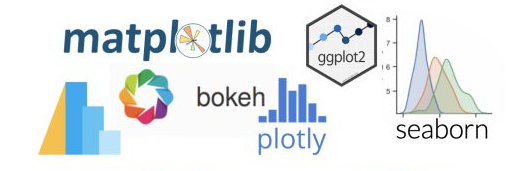
<figcaption aria-hidden="true">Python (and R) visualisation
libraries.</figcaption>
</figure>

We are using [Australian weather
data](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package),
taken from [Kaggle](https://kaggle.com). This dataset is used to build
machine learning models that predict whether it will rain tomorrow,
using data about the weather every day from 2007 to 2017. To download
the data, click [here](data/weatherAUS.csv).

One final note before we get started - This page is a combination of
text and python code. We’ve tried to explain clearly what we’re about to
do before we do it, but do also note the `# comments` within the python
code cells themselves that occasionally explain a specific line of code
in more detail.

## Initial setup

We’re going to import some python packages. Remember that the `plt`,
`np`, `sns` aliases are just for convenience - we could omit this
completely or use different aliases if we prefer.

> **Aside - why `sns`?**
>
> Seaborn being imported as `sns` is an odd convention (they are the
> initials of the fictional character the package was named for) that
> will make it easier to read or copy/paste online examples.

In [1]:
# install necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# suppress some annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

sns.set_theme(style='darkgrid') # https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_context("notebook") # set an overall scale. Notebook is the default. In increasing size: paper, notebook, talk, poster.
plt.rcParams['font.sans-serif'] = ['Calibri','Segoe UI','Arial'] # use a nicer font in matplotlib (if available)

As before, we need to import our dataset. We’re importing the `csv` file
into an initial dataframe called `df` to start with.

In [2]:
# import the dataset
df = pd.read_csv('data/weatherAUS.csv')

## Data manipulation

### Column conversions

Before we start actually generating some visuals, we need to make sure
our Date column contains proper datetimes. We’re also going to drop the
years with partial data so that our dataset only has full years. Finally
we’re going to change the RainTomorrow field to contain a 0 or a 1
rather than yes/no.

In [3]:
# convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# create a column that just contains the year
df['Year'] = df['Date'].dt.year

# drop the partial years (2007,2017)
df = df[~df['Year'].isin([2007,2017])]

# convert 'RainTomorrow' to a numeric variable, where 'Yes' = 1 and 'No' = 0.
df['RainToday']=df['RainToday'].replace({'Yes': 1, 'No': 0, 'NA':0}).fillna(0).astype(int)
df['RainTomorrow']=df['RainTomorrow'].map({'Yes': 1, 'No': 0,'NA': 0}).fillna(0).astype(int); 

# little tip: the semicolon suppresses textual output when we don't want it

### Sort order and other helper tables

We need a month order for our “mmm” months - there is probably an
official way of doing this…

In [4]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

We also need a sort order for our city names to use as a column order
for some of our charts later. We’ll just arrange them alphabetically.

In [5]:
colOrder_top5Cities=['Adelaide','Brisbane','Melbourne','Perth','Sydney']

To enhance a chart we’re going to build later, we’re going to
dynamically calculate some text describing our data range.

In [6]:
# Calculate the date range dynamically; we're going to use this later...
date_min = df['Date'].min().strftime('%Y')
date_max = df['Date'].max().strftime('%Y')
date_range = f"{date_min} - {date_max}"

print(date_range)

2008 - 2016

### Pivoting and grouping

Next, we’re going to create some helper dataframes by filtering,
grouping and pivoting the data. These will be used for different types
of visuals later. Of course, we could have just created these groupings
and pivots inline when we do the actual visualisation, but we’re doing
it this way because:

1.  It’s easier to follow
2.  It’s tidier (and probably faster) to create these dataframes once as
    we’re going to be using them multiple times.

In [7]:
# build a month column
df['Month'] = df['Date'].dt.strftime('%b') # Add a column that just contains the month in mmm format
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True) # Make it categorical using our custom order so that it appears in the right order

# we're going to filter to top 5 cities from now on
df_top5Cities = df[df['Location'].isin(['Perth','Adelaide','Sydney','Melbourne','Brisbane'])]

# a dataframe with the number of rainy days per year and month, and location
df_top5Cities_rainyDays = df_top5Cities.groupby(['Location','Year', 'Month'])['RainToday'].sum().reset_index()

# finally, we're going to create some grouped and pivoted dataframes. Picture these as PivotTables in Excel.
df_top5Cities_Rainfall_grouped = df_top5Cities.groupby(['Location', 'Month'])['Rainfall'].mean().reset_index()
df_top5Cities_Rainfall_pivoted = df_top5Cities_Rainfall_grouped.pivot(index="Location",columns="Month", values="Rainfall")
df_top5Cities_monthly_rainyDays_pivoted = df_top5Cities.groupby(['Location', 'Month','Year'])['RainToday'].sum().reset_index().groupby(['Location','Month'])['RainToday'].mean().reset_index().pivot(index="Location",columns="Month", values="RainToday")

Let’s use `head()` to make sure we understand what each grouped/pivoted
DF is for.

In [8]:
df_top5Cities_Rainfall_grouped.head(2)

In [9]:
df_top5Cities_Rainfall_pivoted.head(2)

In [10]:
df_top5Cities_monthly_rainyDays_pivoted.head(2)

> **Aside: why `df[df[...`?**
>
> ``` python
> df_top5Cities = df[df['Location'].isin(['Perth','Adelaide','Sydney','Melbourne','Brisbane'])]
> ```
>
> -   The first (outer) `df[` tells pandas that we want to select a
>     subset of rows based on some condition.
> -   The second (inner) `df[` is going to tell pandas this condition.
>     In this case, we’re using `isin` to return a dataframe that
>     contains a series of `True` and `False` rows corresponding to
>     whether the rows in our original dataframe had the `Location`
>     column as one of our 5 cities.
> -   The final dataframe is then a filtered copy where the inner
>     condition is `True`.
>
> Yes, there are other ways of doing this! For example by using
> `.query()` to specify our conditions.

## Doing some actual plotting

The Seaborn home page has a very good [introductory
tutorial](https://seaborn.pydata.org/tutorial/introduction.html),
[reference documentation](https://seaborn.pydata.org/api.html), and a
[nice collection of
examples](https://seaborn.pydata.org/examples/index.html). You should
familiarise yourself with the documentation; it’ll pay off massively if
you actually grasp what each function and argument is for, rather than
just copy/pasting examples and tweaking them until they work (without
really understanding what they’re doing).

### A basic one-line line chart

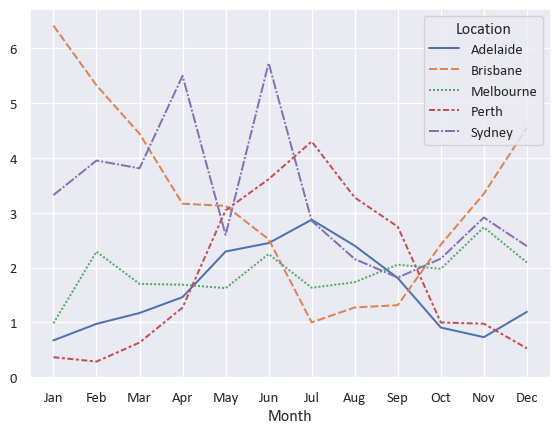

In [11]:
sns.lineplot(
  data=df_top5Cities_Rainfall_pivoted.T #.T gives the transpose (flips rows and columns)
  ) 

### Just a little bit of customisation - a bar chart

<https://seaborn.pydata.org/generated/seaborn.barplot.html>

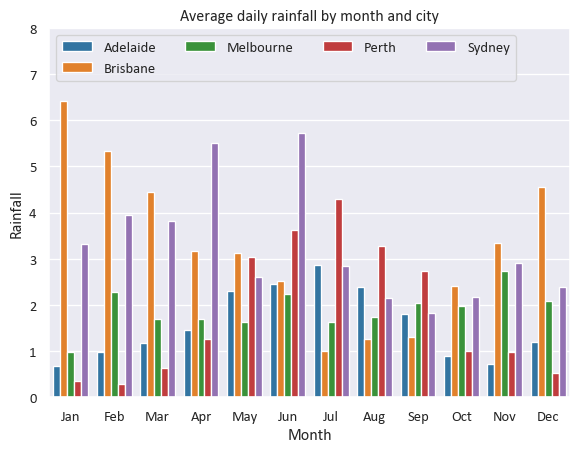

In [12]:
our_barplot = sns.barplot(
  data=df_top5Cities_Rainfall_grouped 
  ,x="Month"
  ,y="Rainfall"
  ,hue="Location" # read "hue" as "series"
  ,palette="tab10" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
  )

our_barplot.set(title='Average daily rainfall by month and city',ylim=(0,8))

sns.move_legend(our_barplot,"upper left", title=None, ncol=4) # https://seaborn.pydata.org/generated/seaborn.move_legend.html

> **Aside - why did we need to set the title *after* the `sns.barplot`
> call?**
>
> The `barplot` function provided by Seaborn doesn’t actually allow
> setting of a title - it just generates a plot (including its axes) and
> returns this as a matplotlib `Axes` object (recall we mentioned
> earlier that Seaborn is a layer on top of the matplotlib library). By
> using the `.set(...)` method on our barplot object, we can *modify*
> this returned object to give it a title. We also could have used this
> to customise our axis labels (the defaults are fine here), set axis
> limits, or things like tick labels.

### Heatmaps

The Seaborn `heatmap` function will easily let us create a
two-dimensional heatmap visual with a specific colour theme and custom
number formatting.

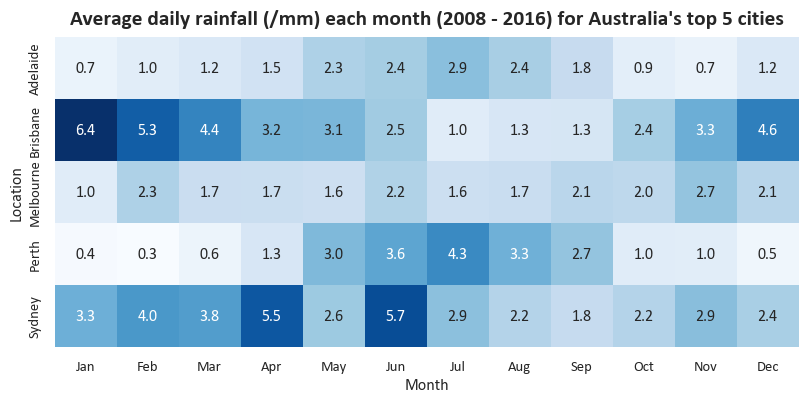

In [13]:
# We need to use some matplotlib code to set our output size, add a title, and capitalise our x-axis label
f,ax = plt.subplots(figsize=(10, 5)) # matplotlib subplots are a common way of setting a figure layout
ax.set_title(f"Average daily rainfall (/mm) each month ({date_range}) for Australia's top 5 cities", fontsize=16, fontweight="bold", pad=10) # using our previously set date_range variable

sns.heatmap(df_top5Cities_Rainfall_pivoted # Heatmap expects rectangular (pivot-like) data
            ,annot=True # Put numbers inside the cells
            ,fmt=".1f" # Make the numbers have 1 decimal place
            ,square=True # Square vs rectangular cells
            ,cbar=False # Get rid of the colourbar legend on the side
            ,cmap="Blues" # Seems appropriate for rainfall. Colourmaps reference: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
            ,ax=ax # Tell it to use the matplotlib axes we created earlier
           )

### Another heatmap with some further tweaks

We can make our heatmap look just a little better by apply some tweaks
to the subplots object.

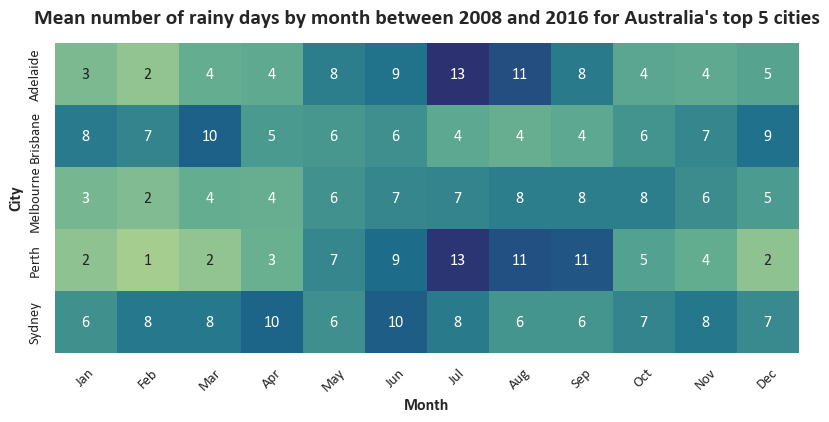

In [14]:
# Again setting up matplotlib subplots so that we can make some changes later
f,ax = plt.subplots(figsize=(10, 5)) 

sns.heatmap(df_top5Cities_monthly_rainyDays_pivoted # Heatmap expects rectangular (pivot-like) data
            ,annot=True # Put numbers inside the cells
            ,fmt=".0f" # Force the number format
            ,square=True # Square vs rectangular cells
            ,cbar=False # Get rid of the colourbar legend on the side
            ,cmap="crest" # Colourmaps reference: https://matplotlib.org/stable/users/explain/colors/colormaps.html 
            ,ax=ax # Tell it to use the matplotlib axes we created earlier
           )

# We need to use some matplotlib code to set our output size, add a title, and capitalise our x-axis label
ax.tick_params(axis='x', labelsize=11, rotation=45) # I think 45-degree month labels look nicer, but this is a matter of taste.
ax.tick_params(axis='y', labelsize=11)

# Manually changing our axis labels for more control
ax.set_xlabel("Month",fontweight="bold",fontsize=12) 
ax.set_ylabel("City",fontweight="bold",fontsize=12)

# Set our title dynamically
ax.set_title(f"Mean number of rainy days by month between {date_min} and {date_max} for Australia's top 5 cities", fontsize=16, fontweight="bold", pad=15);

### A fancy multi-chart visual

This chart uses the `boxgrid` object to arrange multiple different
subcharts. We’re actually generating two sets of different visuals
(`linegrid` and `boxgrid`) in one output. If you’re not sure what the
`for [...] in [...]` syntax means, don’t worry - this will be covered in
a future session.

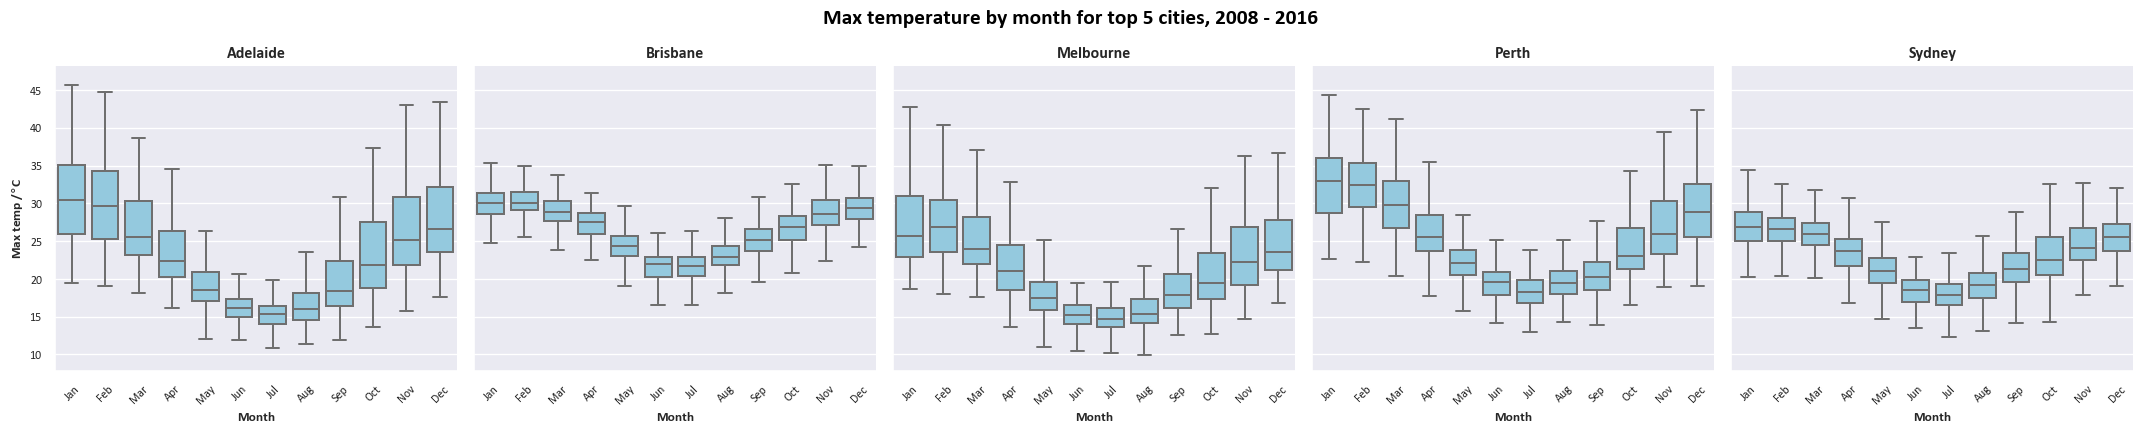

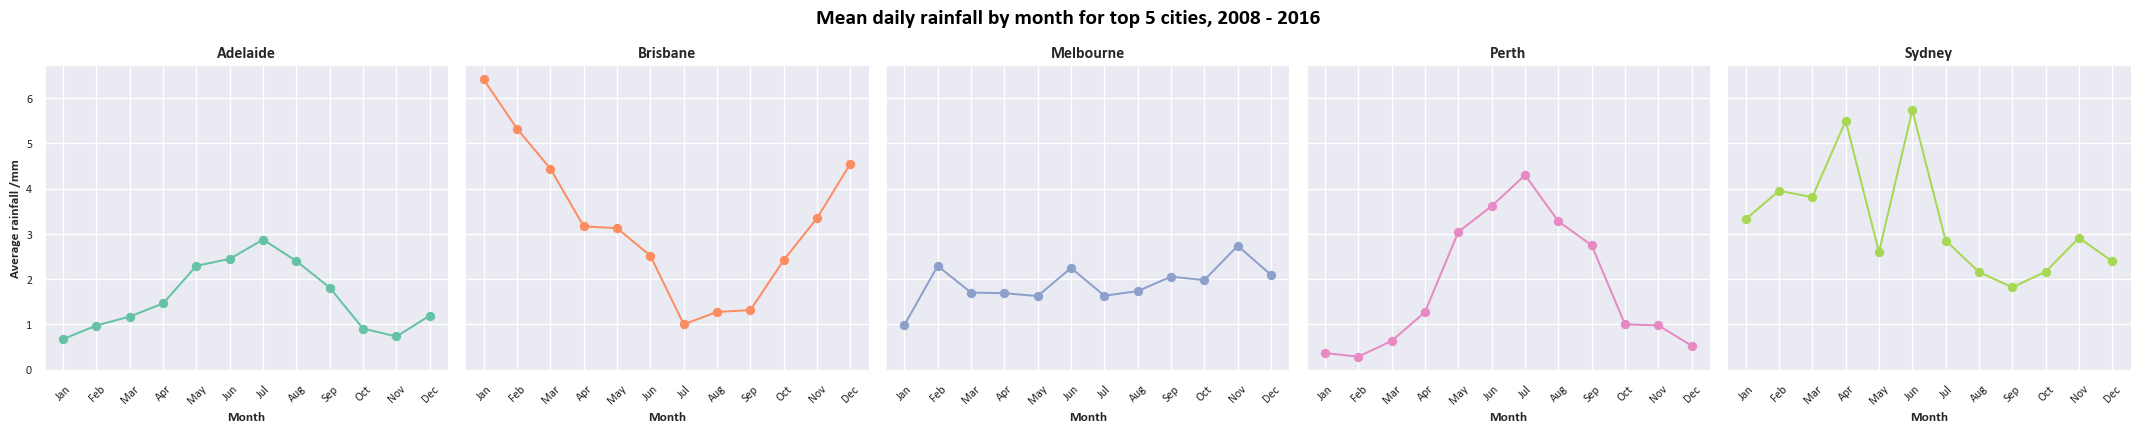

In [15]:
# Setting up the grid of box plots
# Box plots are a bit of a rabbit hole and are extremely customisable; we're mostly using defaults here
boxgrid = sns.FacetGrid(df_top5Cities 
                        ,col="Location" # Defining the different facets
                        ,col_wrap=5, height=4.5 # Layout and sizing for our facet grid
                        ,col_order=colOrder_top5Cities  # Using our alphabetical order of city names to arrange our facets
)
boxgrid.map(sns.boxplot # This is what tells sns what sort of plots we want in our grid
            ,"Month" # X
            ,"MaxTemp" # Y
            ,linewidth=1.5
            ,color="skyblue"
            ,order=month_order
            ,fliersize=0 # Seaborn boxplots by default include markers for outliers, which it calls "fliers". For this chart we'd like to disable these.
            ) 

# Setting up the grid of line plots
# Using the default matplotlib plot here
linegrid = sns.FacetGrid(df_top5Cities.groupby(['Location', 'Month'])['Rainfall'].mean().reset_index()
                         ,col="Location" 
                         ,hue="Location",palette="Set2" 
                         ,col_wrap=5, height=4.5 
                         ,col_order=colOrder_top5Cities
)
linegrid.map(plt.plot, "Month", "Rainfall",marker="o")

# Formatting axes
for ax in boxgrid.axes.flat:
    ax.tick_params(axis='x', labelsize=9, rotation=45)
    ax.tick_params(axis='y', labelsize=9)
for ax in linegrid.axes.flat:
    ax.tick_params(axis='x', labelsize=9, rotation=45)
    ax.tick_params(axis='y', labelsize=9)

linegrid.set_titles(col_template="{col_name}",fontweight="bold",fontsize=16)
linegrid.set_axis_labels("Month","Average rainfall /mm",fontweight="bold",fontsize=10)
boxgrid.set_titles(col_template="{col_name}",fontweight="bold",fontsize=16)
boxgrid.set_axis_labels("Month","Max temp /$\\degree$C",fontweight="bold",fontsize=10)

# Setting overall titles and spacing
linegrid.fig.suptitle(f"Mean daily rainfall by month for top 5 cities, {date_range}", fontsize=16, color='black',fontweight='bold') 
boxgrid.fig.suptitle(f"Max temperature by month for top 5 cities, {date_range}", fontsize=16, color='black',fontweight='bold') 
linegrid.fig.subplots_adjust(top=0.85)  
boxgrid.fig.subplots_adjust(top=0.85);

### “Small multiples”-type time-series grid

This is mostly based on the example given at
<https://seaborn.pydata.org/examples/timeseries_facets.html>.

Firstly, for this one we need another dataframe that just contains the
Sydney data.

In [16]:
df_Sydney = df[df['Location']=="Sydney"].groupby(['Month', 'Location','Year'], as_index=False)['MaxTemp'].max()

We’re going to use the `relplot` function to create a grid of plots with
a specific set of variables across its rows and columns. For each cell
we’re plotting that year’s data with a different colour, and plotting
all the other years in grey in the background.

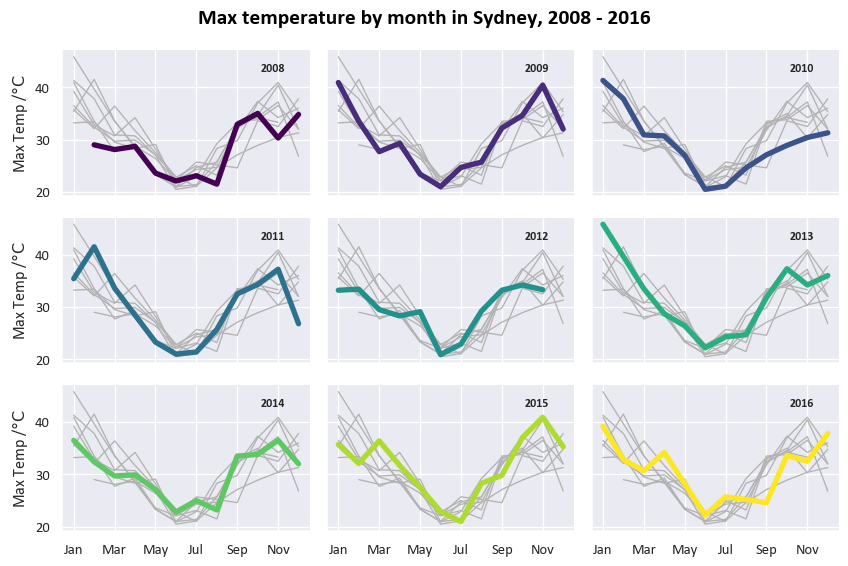

In [17]:
# plot each year's time series in its own facet
g = sns.relplot(data=df_Sydney
                ,x="Month"
                ,y="MaxTemp"
                ,col="Year"
                ,hue="Year"
                ,kind="line"
                ,palette="viridis"
                ,linewidth=4
                ,zorder=5
                ,col_wrap=3, height=2, aspect=1.5, legend=False,
)

# iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8
            ,.85
            ,year
            ,transform=ax.transAxes
            ,fontweight="bold",fontsize=9)

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_Sydney, x="Month", y="MaxTemp", units="Year",
        estimator=None, color=".7", linewidth=1, ax=ax
    )

# reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# tweak the supporting aspects of the plot
g.set_titles("")
g.fig.suptitle(f"Max temperature by month in Sydney, {date_range}", fontsize=16, color='black',fontweight='bold') 
g.set_axis_labels("", "Max Temp /$\\degree \\mathrm{C}$");
g.tight_layout();